In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import (
    calinski_harabasz_score,
    rand_score,
    silhouette_score,
)
from torch.utils.data import DataLoader

from vade.data import DATASETS
from vade.device import DEVICE
from vade.model import VADE
from vade.evaluate.vade import evaluate_vade
from pathlib import Path

In [2]:
dataset_name = "MNIST"

In [3]:
model = (
    VADE.load_from_checkpoint(
        "results/2025-01-12__21-31-18/MNIST/VADE/BasicTraining/lightning_logs/version_0/checkpoints/best_model-epoch=27-val_loss=135.1353-train_loss=131.8068.ckpt"
    )
    .to(DEVICE)
    .double()
)

In [4]:
dataset = DATASETS[dataset_name]["test"]
dataloader = DataLoader(dataset, 32)

### Prediction generation

In [5]:
predictions = []
latent_representations = []
true_labels = []
for X, y in dataloader:
    X = X.to(DEVICE)
    with torch.no_grad():
        predictions.append(model(X))
        latent_representations.append(model.mu_encoder(model.encode(X)))
    true_labels.append(y)
predictions = torch.concat(predictions).cpu().numpy()
latent_representations = torch.concat(latent_representations).cpu().numpy()
true_labels = torch.concat(true_labels).cpu().numpy()
n_clusters = np.unique(true_labels).shape[0]

### Clustering of latent space vs true classes

In [6]:
clustering = KMeans(n_clusters=n_clusters, random_state=123)
clusters = clustering.fit_predict(latent_representations)
print(f"{rand_score(true_labels, clusters)}")

0.912028902890289


### Clustering metrics of latent space

In [7]:
print(f"{silhouette_score(latent_representations, clusters).item()=}")
print(f"{calinski_harabasz_score(latent_representations, clusters).item()=}")

silhouette_score(latent_representations, clusters).item()=0.1871534373255854
calinski_harabasz_score(latent_representations, clusters).item()=1399.3753985263572


### Clusters visualizations
* (with true labels as colors)

In [8]:
stratified_sample_X = []
stratified_sample_true_labels = []
for i in range(n_clusters):
    stratified_sample_X.append(latent_representations[true_labels == i][:100])
    stratified_sample_true_labels.append(true_labels[true_labels == i][:100])
stratified_sample_X = np.concat(stratified_sample_X)
stratified_sample_true_labels = np.concat(stratified_sample_true_labels)

In [9]:
stratified_sample_X = np.vstack(
    [
        stratified_sample_X,
        model.mu.detach().cpu().numpy(),
        clustering.cluster_centers_,
    ]
)
stratified_sample_true_labels = np.concat(
    [stratified_sample_true_labels, np.ones(10) * -1, np.ones(10) * -2]
)

In [10]:
reduced_data = TSNE(2).fit_transform(stratified_sample_X)

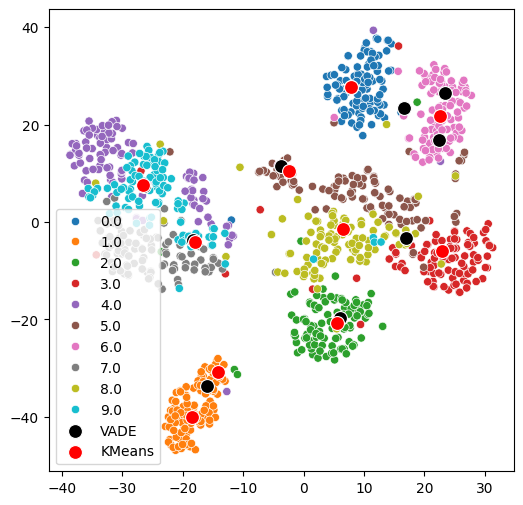

In [11]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(
    x=reduced_data[:, 0][stratified_sample_true_labels > -1],
    y=reduced_data[:, 1][stratified_sample_true_labels > -1],
    hue=stratified_sample_true_labels[
        stratified_sample_true_labels > -1
    ].tolist(),
    palette="tab10",
)
sns.scatterplot(
    x=reduced_data[:, 0][stratified_sample_true_labels == -1],
    y=reduced_data[:, 1][stratified_sample_true_labels == -1],
    color="black",
    s=100,
    label="VADE",
)
sns.scatterplot(
    x=reduced_data[:, 0][stratified_sample_true_labels == -2],
    y=reduced_data[:, 1][stratified_sample_true_labels == -2],
    color="red",
    s=100,
    label="KMeans",
)
plt.legend()

### Observation from each cluster 
* (for img visualize, for HAR calculate distance from points of this cluster, compare to distance from other cluster, compare to distances of real observations)

In [12]:
assert isinstance(model, VADE), "This result supports only VADE"

In [13]:
diff = model.mu.unsqueeze(1) - model.mu.unsqueeze(0)

pairwise_distances = torch.norm(diff, dim=-1)

num_tensors = model.mu.size(0)
average_distance = pairwise_distances.sum() / (num_tensors * (num_tensors - 1))
average_distance

tensor(5.4002, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)

In [14]:
model.logvar.exp().mean(dim=1)

tensor([1.2342, 1.6403, 2.4871, 1.3383, 0.9853, 0.9815, 1.6699, 1.0108, 1.4240,
        2.3724], device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward1>)

In [15]:
from torch import Tensor

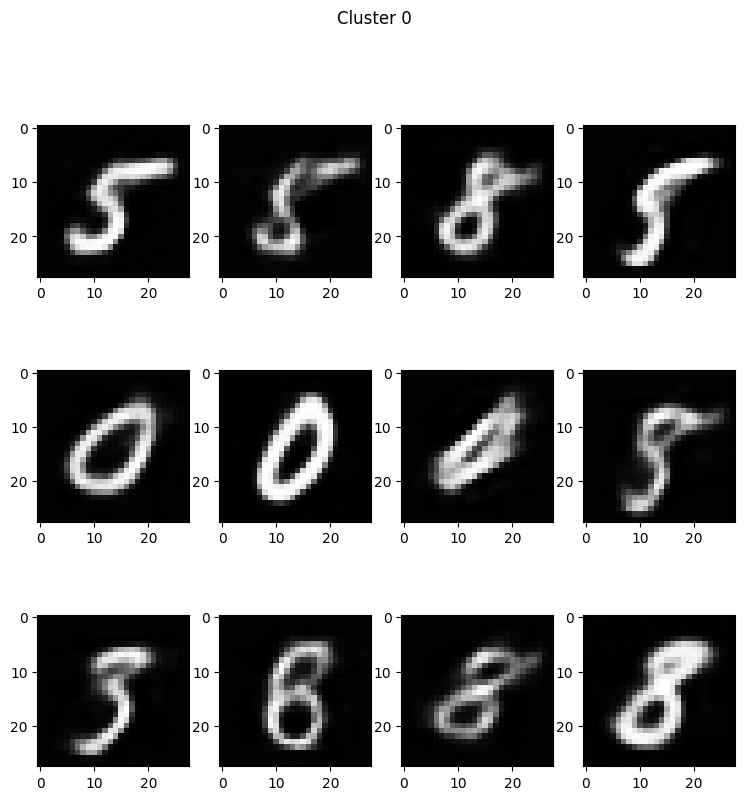

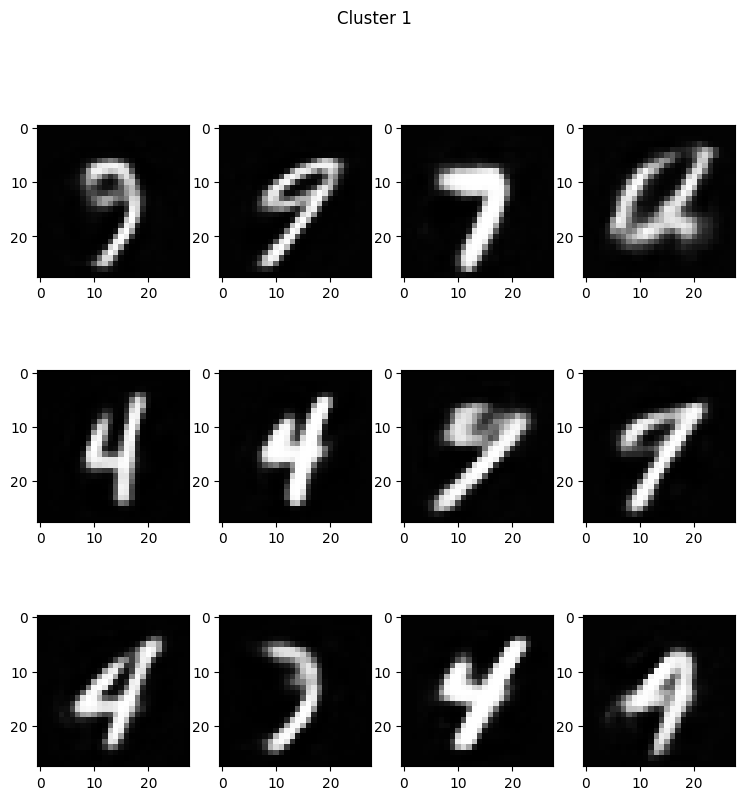

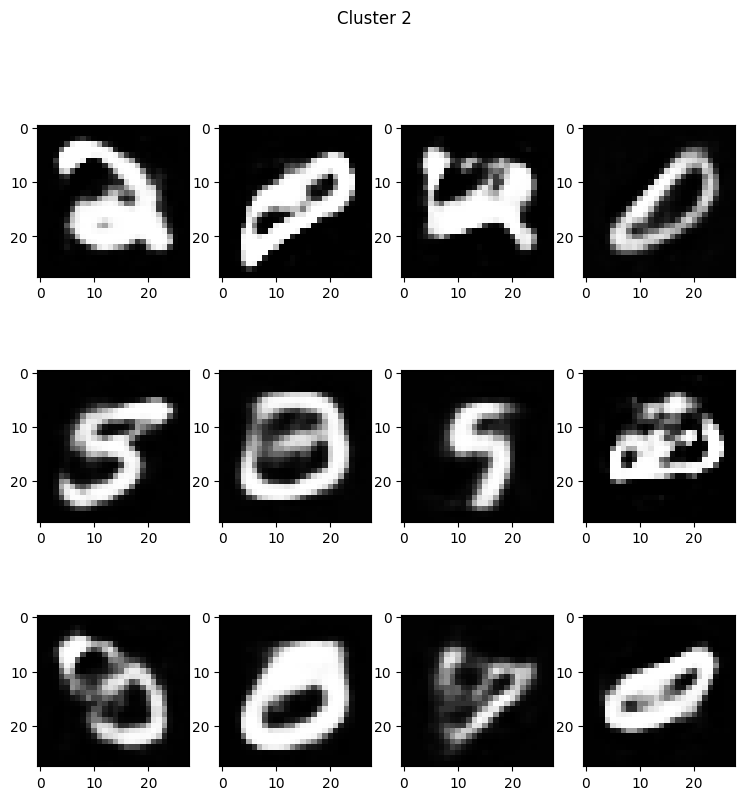

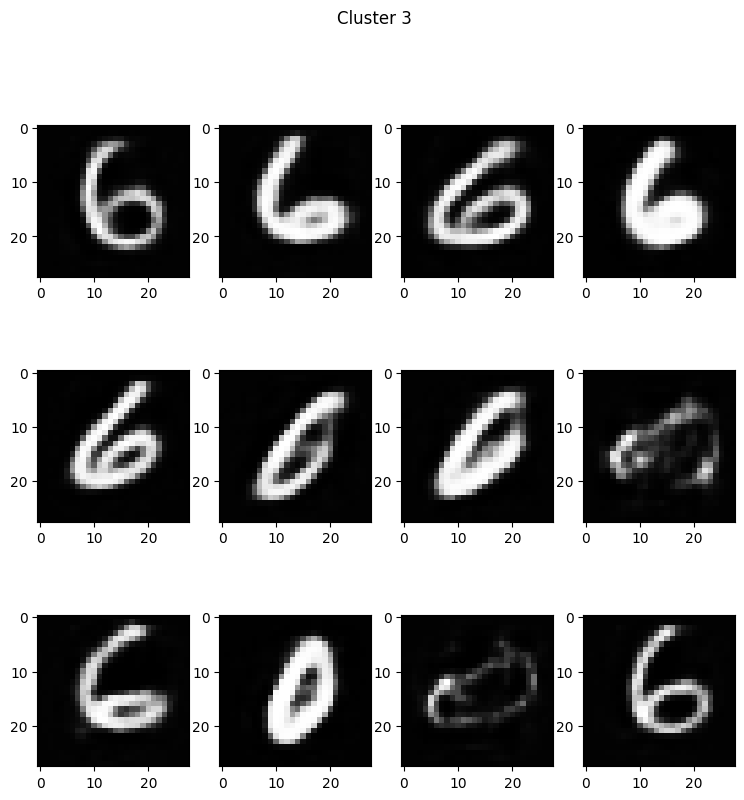

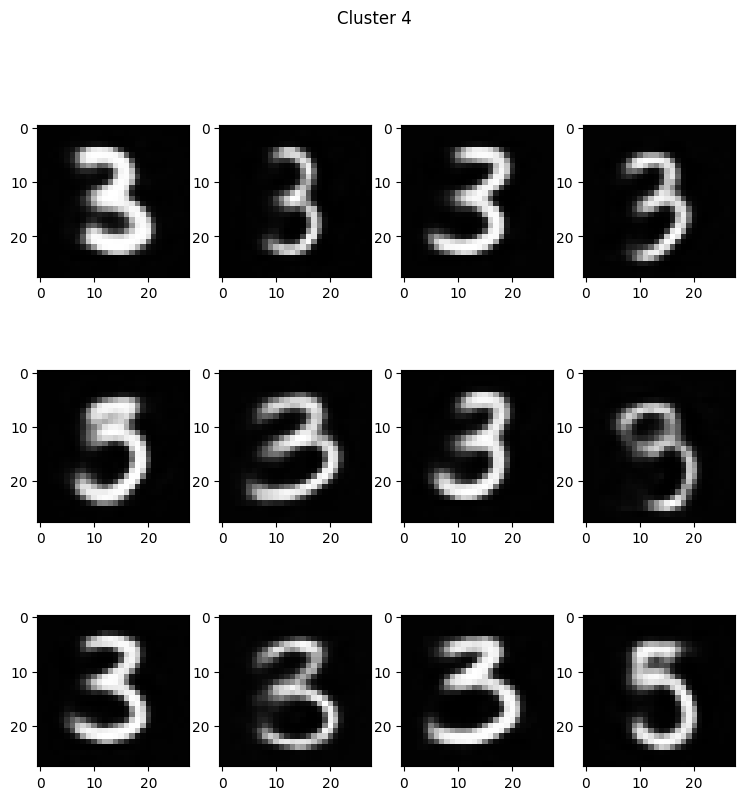

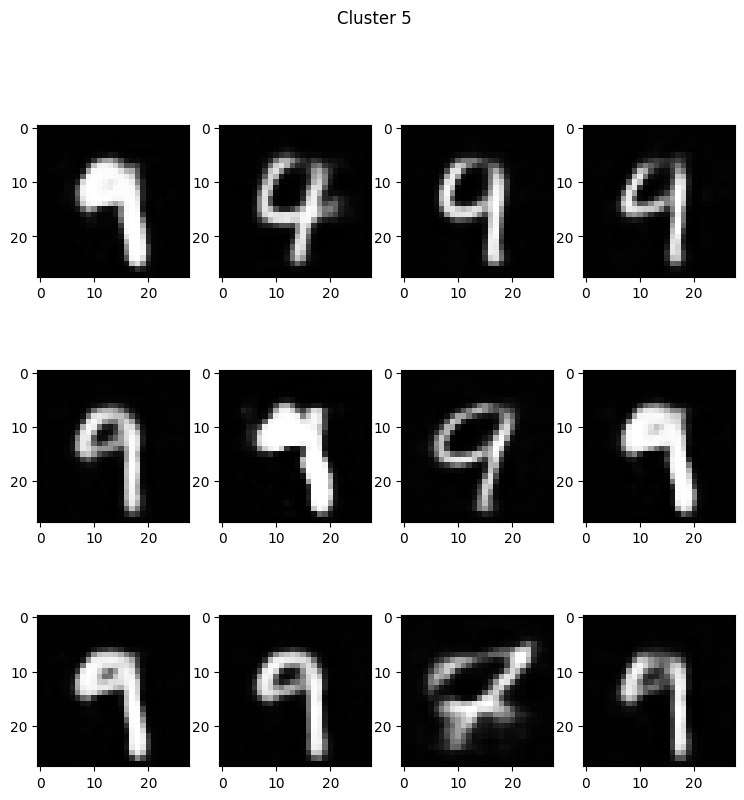

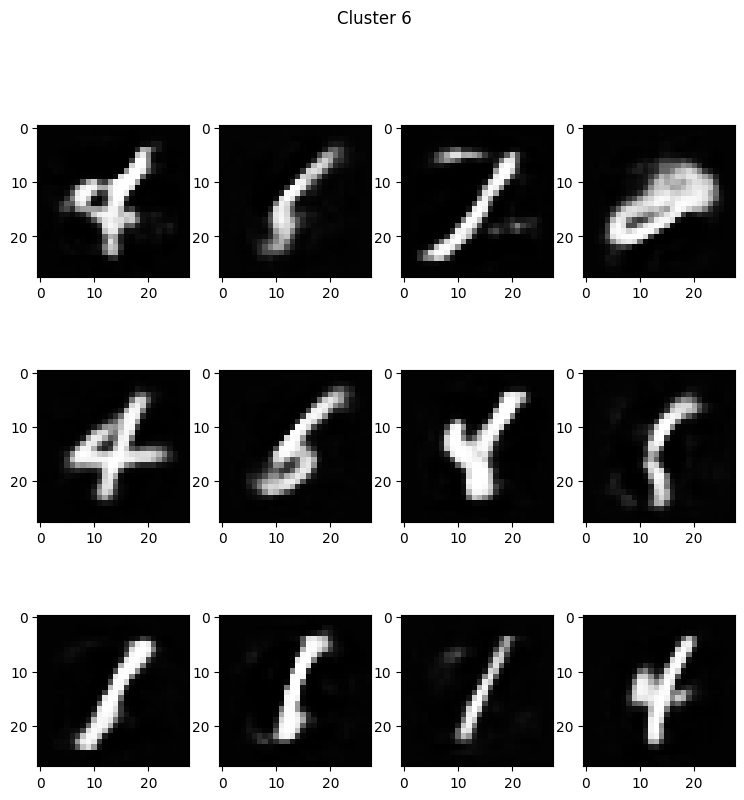

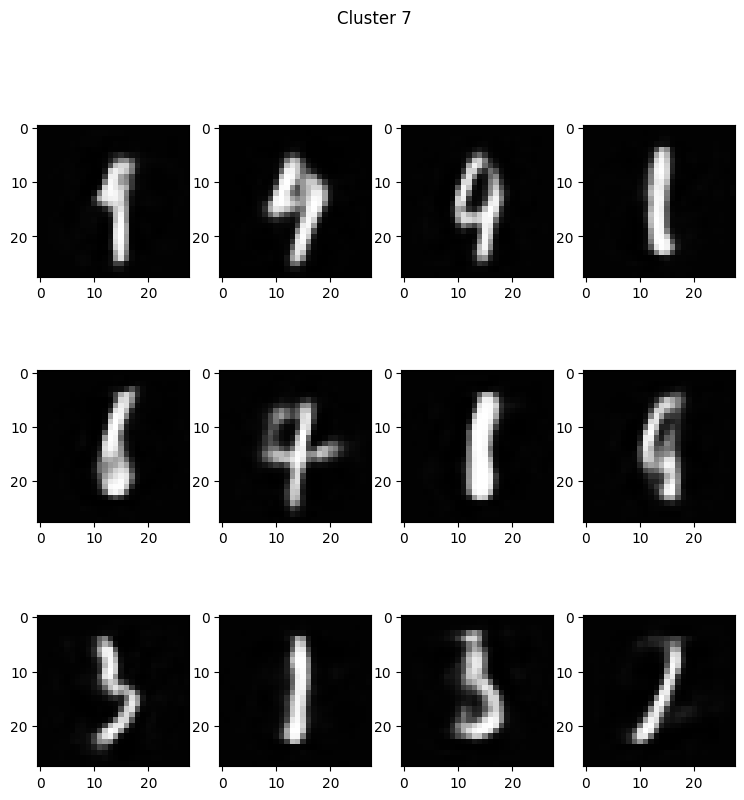

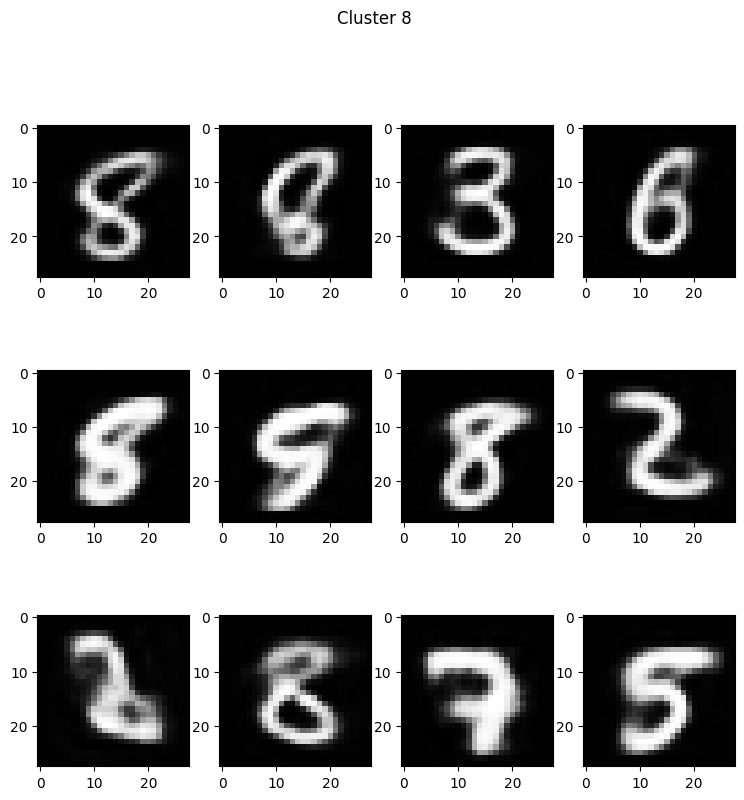

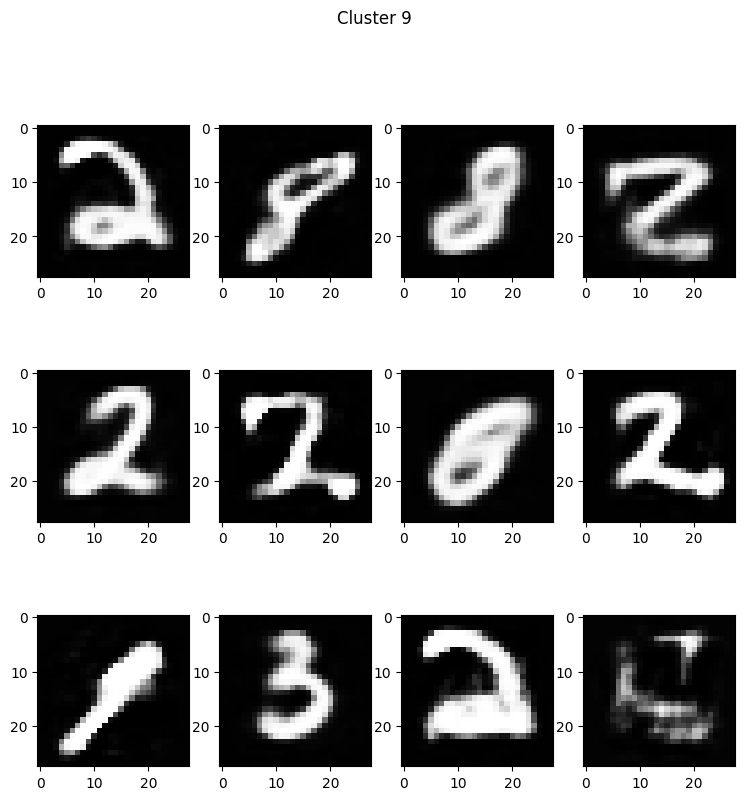

In [16]:
for class_ in range(10):
    fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(9, 9))
    for idx in range(12):
        r = torch.randn(size=(model.layers_sizes[-1],)).cuda()
        z = (
            r * torch.exp(model.logvar[class_])
            + Tensor(clustering.cluster_centers_[class_]).cuda()
        )
        mu, logvar = model.mu_encoder(z), model.logvar_encoder(z)
        output = model.decode(z)
        output_img = output.reshape(28, 28).cpu().detach().numpy()
        ax_to_plot = ax[idx // 4][idx % 4]
        ax_to_plot.imshow(output_img, cmap="gray")
    fig.suptitle(f"Cluster {class_}")

In [17]:
classes = []
data = []
for X, y in dataloader:
    X = X.to(DEVICE)
    data.append(X)
    with torch.no_grad():
        classes.append(model.classify(X))
classes = torch.concat(classes)
X = torch.concat(data)

In [18]:
within_distances = []
between_distances = []
for class_ in range(model.n_classes):
    r = torch.randn(size=(model.layers_sizes[-1],)).cuda()
    with torch.no_grad():
        z = (r * torch.exp(model.logvar[class_])) + Tensor(
            clustering.cluster_centers_[class_]
        ).cuda()
        mu, logvar = model.mu_encoder(z), model.logvar_encoder(z)
        latent = model.reparametrize(mu, logvar)
        output = model.decode(z)
    within_distances.append(
        torch.cdist(output.unsqueeze(0), X[classes == class_].double()).mean()
    )
    between_distances.append(
        torch.cdist(output.unsqueeze(0), X[classes != class_].double()).mean()
    )
within_distances = torch.mean(torch.stack(within_distances))
between_distances = torch.mean(torch.stack(between_distances))

In [19]:
within_distances

tensor(9.7243, device='cuda:0', dtype=torch.float64)

In [20]:
between_distances

tensor(9.5563, device='cuda:0', dtype=torch.float64)

In [21]:
output_root_path = Path(
    "results/2025-01-12__21-31-18/MNIST/VADE/BasicTraining"
)
model = (
    VADE.load_from_checkpoint(
        "results/2025-01-12__21-31-18/MNIST/VADE/BasicTraining/lightning_logs/version_0/checkpoints/best_model-epoch=27-val_loss=135.1353-train_loss=131.8068.ckpt"
    )
    .to(DEVICE)
    .double()
)

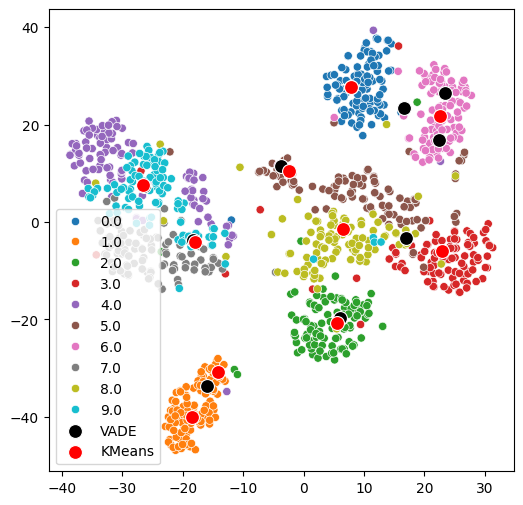

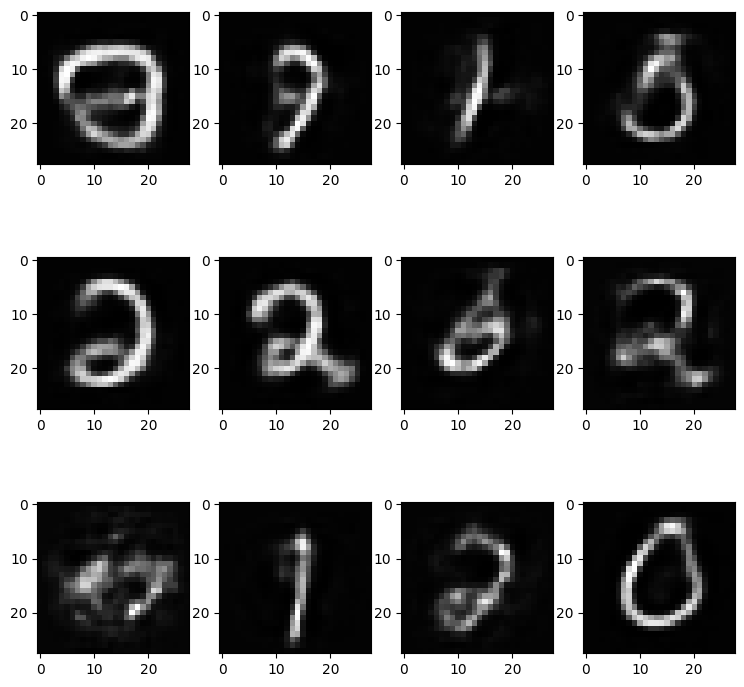

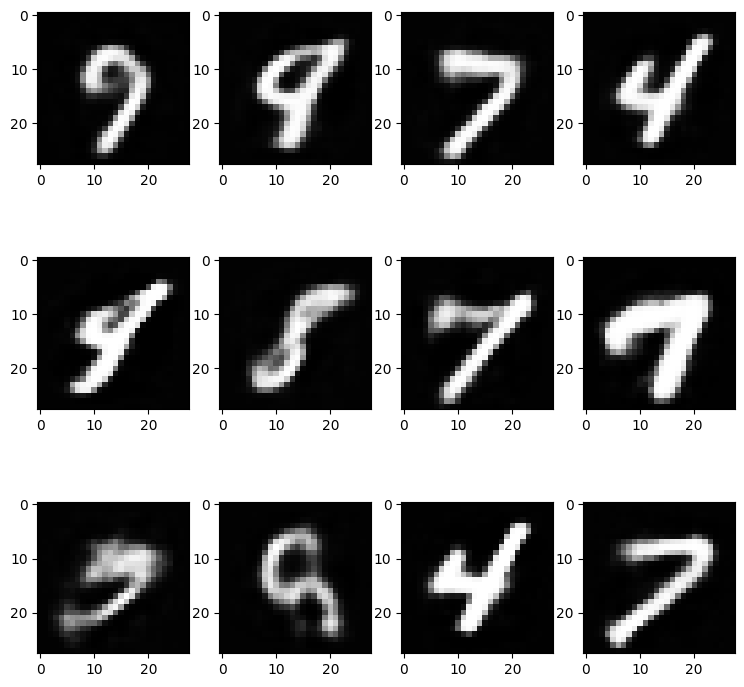

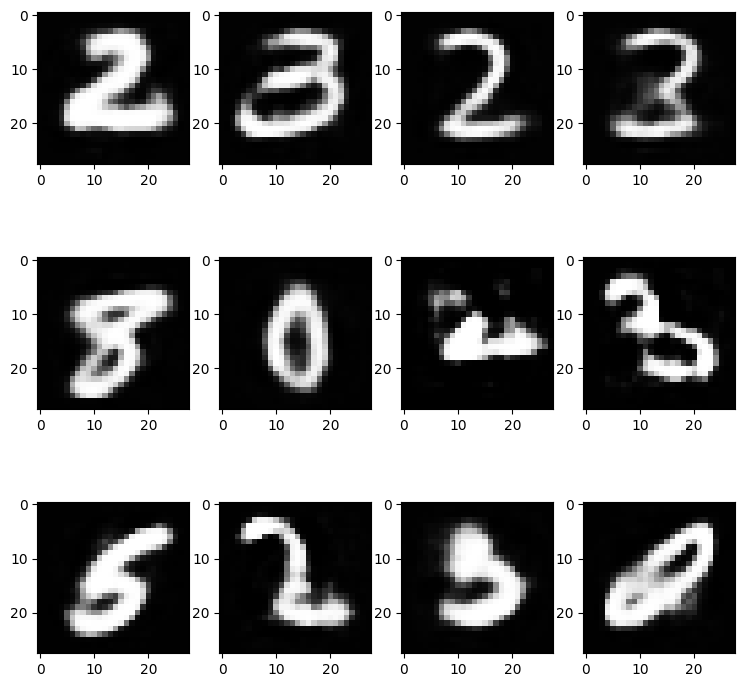

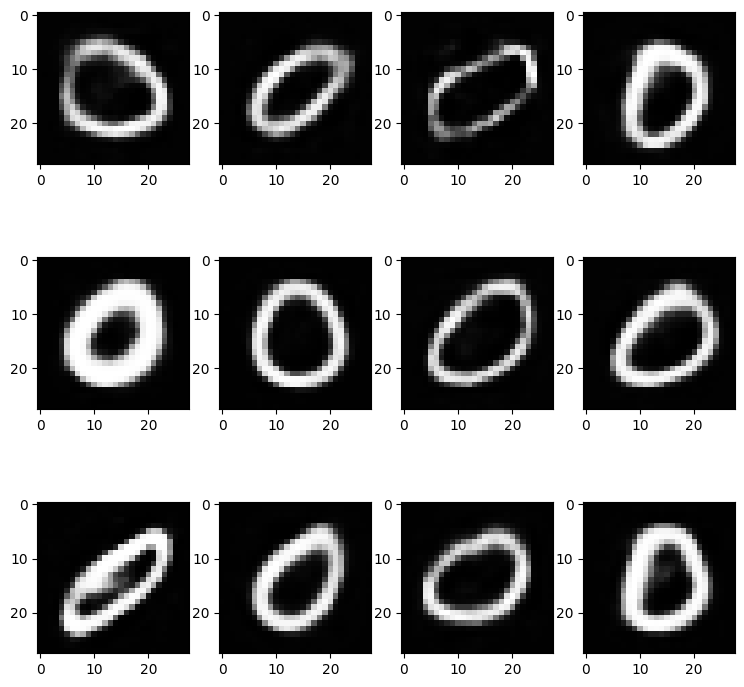

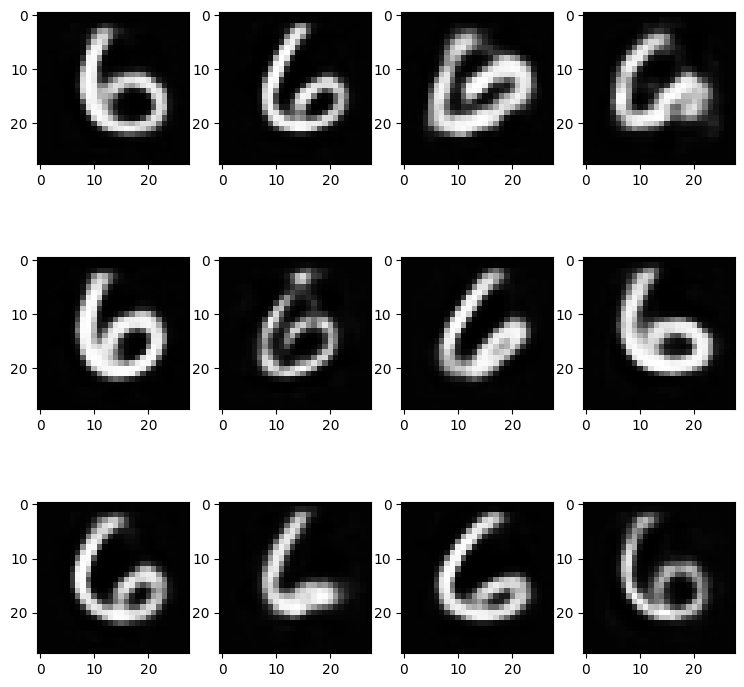

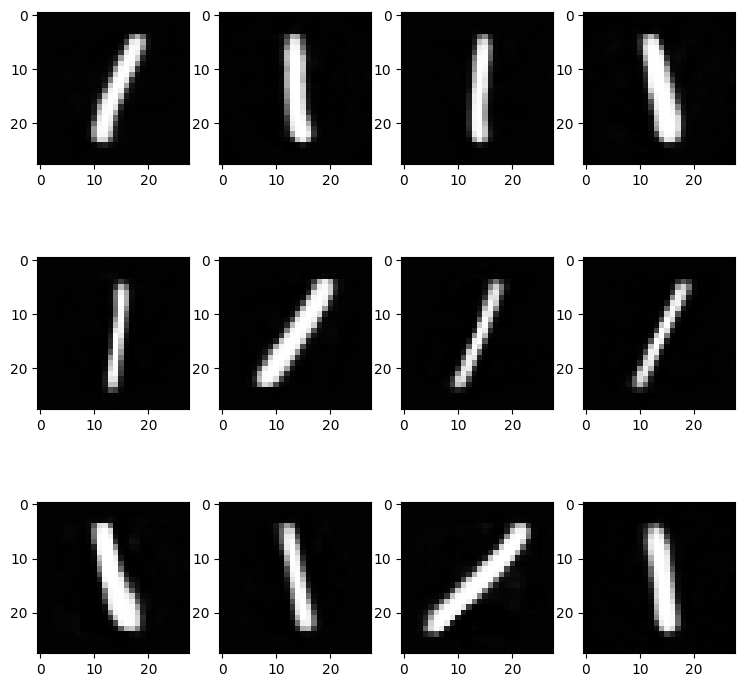

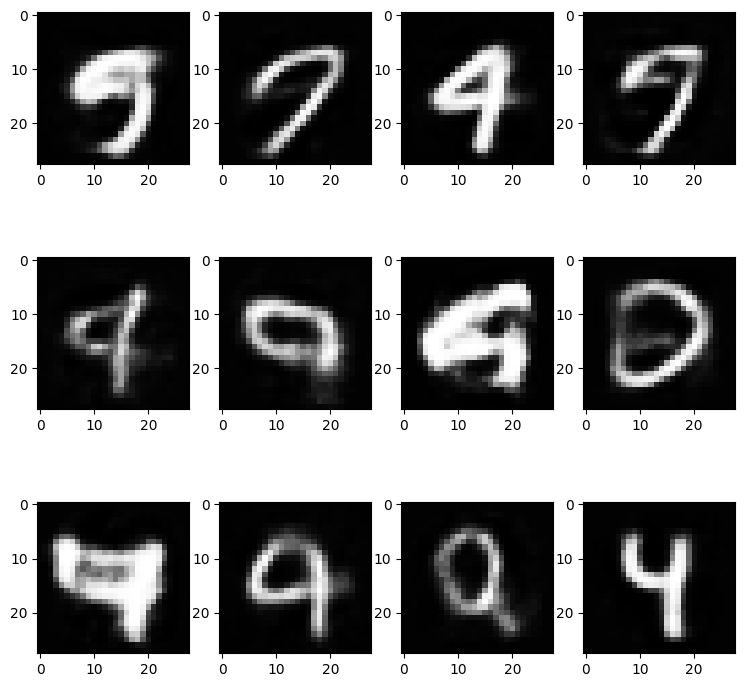

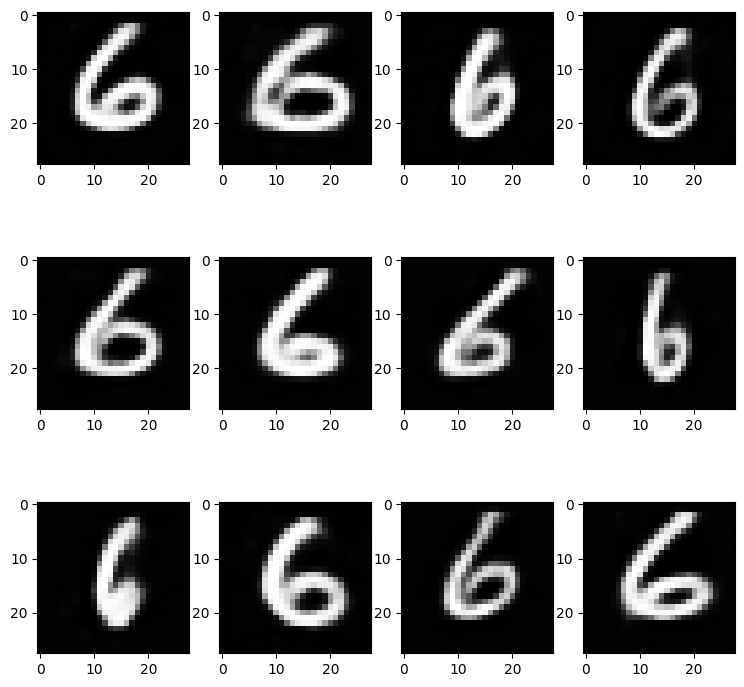

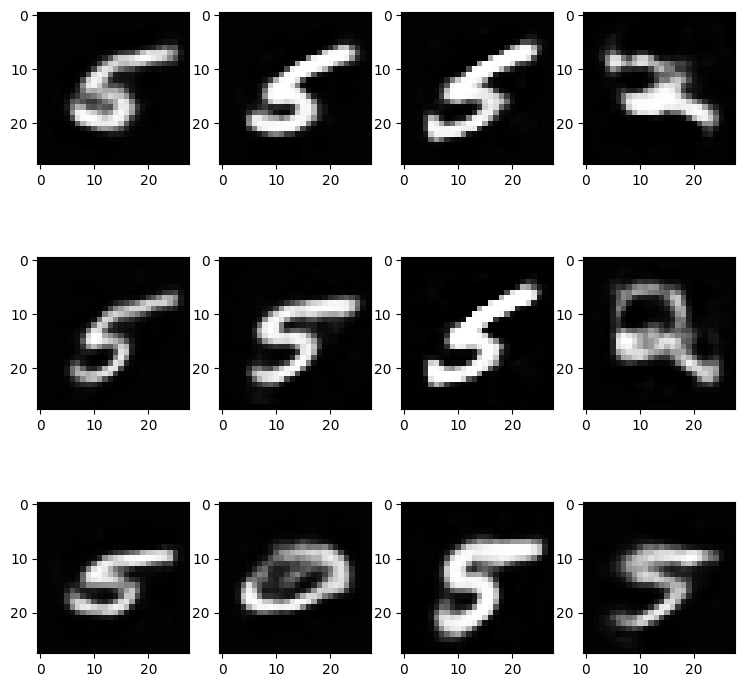

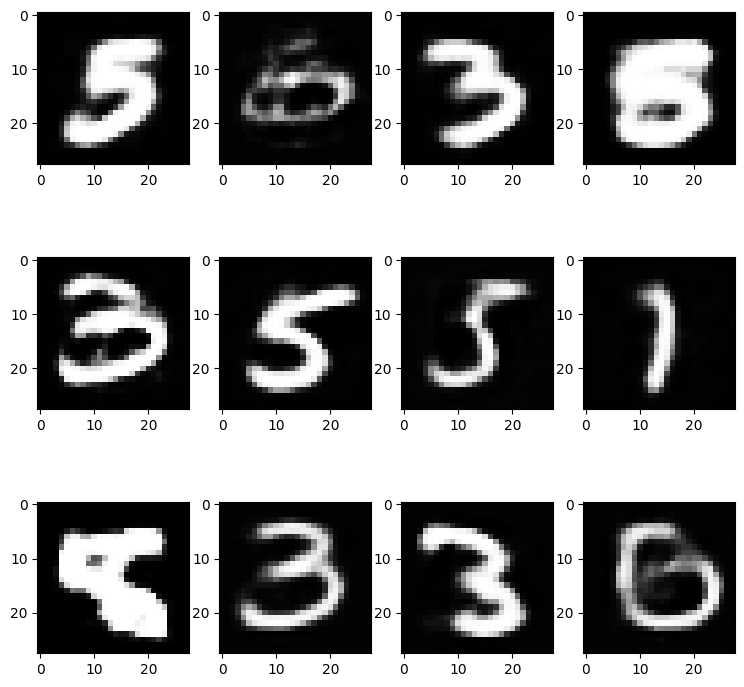

In [24]:
evaluate_vade(model, dataloader, output_root_path)